# First-Time Eligible Arbitration Salary Prediction

## 1. Introduction

In this task, I worked with a subset of **batting-level** data from players' **career**, **platform year**(the year before the year of their arbitration contract), **py-1**(the year before platform year) and **py-2**(two years before platform year). Detailed definitions of the variables can be found in the excel file within the same repository. On the basis of this data, the goal of this research was to develop a reliable framework which is capable of **predicting a player’s first-time eligible arbitration salary(salary_1te)** and **placing them into tiers**. The framework is basically composed of below parts: feature preprocessing, model building, hyperparameter tuning, model evaluation, and first-time eligible arbitration salary prediction.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from numpy import isnan
from sklearn.impute import KNNImputer
import lightgbm as lgb
from bayes_opt import BayesianOptimization 
import smogn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.inspection import permutation_importance

## 2. Feature Preprocessing
### 2.1 Feature encoding and data type conversion

I checked the data type and value of each column and noticed that some value should be replaced. For example, 'D' represented DH in **primary_position** when other positions are represented by number 1-9; 'N' represented non in **py_as**(all-star appearance or not), **py_mvp**(mvp award win or not), **py_ss**(silver slugger win or not), etc; 'NA' represented missing value in **'py-2 war'**. I then encoded several columns, including **primary_position**, **platform_year**, **py_as**, **py_mvp**, **py_ss**, **py-1 as**, **py-1 mvp**, **py-1 ss**, **py-2 as**, **py-2 mvp**, **py-2 ss**, whose data types are object(except for **platform_year**, which is numeric but should be treated as a categorical variable). Besides, I converted the data types of those columns into category.

In [2]:
df = pd.read_excel(r'C:\Users\allen\Desktop\Baseball Analytics Coding Task\HOU\Arbitration_1TE_POS_Market.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 84 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   player_id         279 non-null    int64  
 1   primary_position  279 non-null    object 
 2   age               279 non-null    int64  
 3   platform_year     279 non-null    int64  
 4   mls               279 non-null    float64
 5   salary_1te        279 non-null    int64  
 6   salary_py         279 non-null    float64
 7   career_pa         279 non-null    int64  
 8   career_r          279 non-null    int64  
 9   career_h          279 non-null    int64  
 10  career_hr         279 non-null    int64  
 11  career_rbi        279 non-null    int64  
 12  career_tb         279 non-null    int64  
 13  career_sb         279 non-null    int64  
 14  career_avg        279 non-null    float64
 15  career_obp        279 non-null    float64
 16  career_slg        279 non-null    float64
 1

In [4]:
# Feature encoding and data type conversion
df = df.replace({'D':0, 'N':0, 'NA':np.nan})

for feature in ['primary_position', 'platform_year', 'py_as', 'py_mvp', 'py_ss', 'py-1 as', 'py-1 mvp', 'py-1 ss', 'py-2 as', 
                'py-2 mvp', 'py-2 ss']:
    le = preprocessing.LabelEncoder()
    le.fit(df[feature])
    encoded_label = le.transform(df[feature])
    df[feature] = pd.DataFrame(encoded_label)
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

categorical_variables = ['primary_position', 'platform_year', 'py_as', 'py_mvp', 'py_ss', 'py-1 as', 'py-1 mvp', 'py-1 ss', 
                         'py-2 as', 'py-2 mvp', 'py-2 ss']
for variable in categorical_variables:
    df[variable] = df[variable].astype("category")

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8}
{2010: 0, 2011: 1, 2012: 2, 2013: 3, 2014: 4, 2015: 5, 2016: 6, 2017: 7, 2018: 8, 2019: 9}
{0: 0, 1: 1}
{0: 0, 1: 1, 2: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7, 14: 8, 16: 9, 21: 10, 25: 11, 28: 12}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1, 2: 2, 4: 3, 5: 4, 11: 5, 12: 6, 16: 7, 17: 8, 18: 9, 19: 10, 20: 11, 24: 12}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 2: 1, 3: 2, 9: 3, 11: 4, 19: 5, 20: 6, 22: 7, 23: 8}
{0: 0, 1: 1}


### 2.2 Pearson correlation heatmap

I also plotted the Pearson correlation heatmap and see the correlation between independent variables and the output variable **salary_1te**. 

The correlation coefficient has values between -1 to 1

— A value closer to 0 implies weaker correlation (exact 0 implying no correlation)

— A value closer to 1 implies stronger positive correlation

— A value closer to -1 implies stronger negative correlation

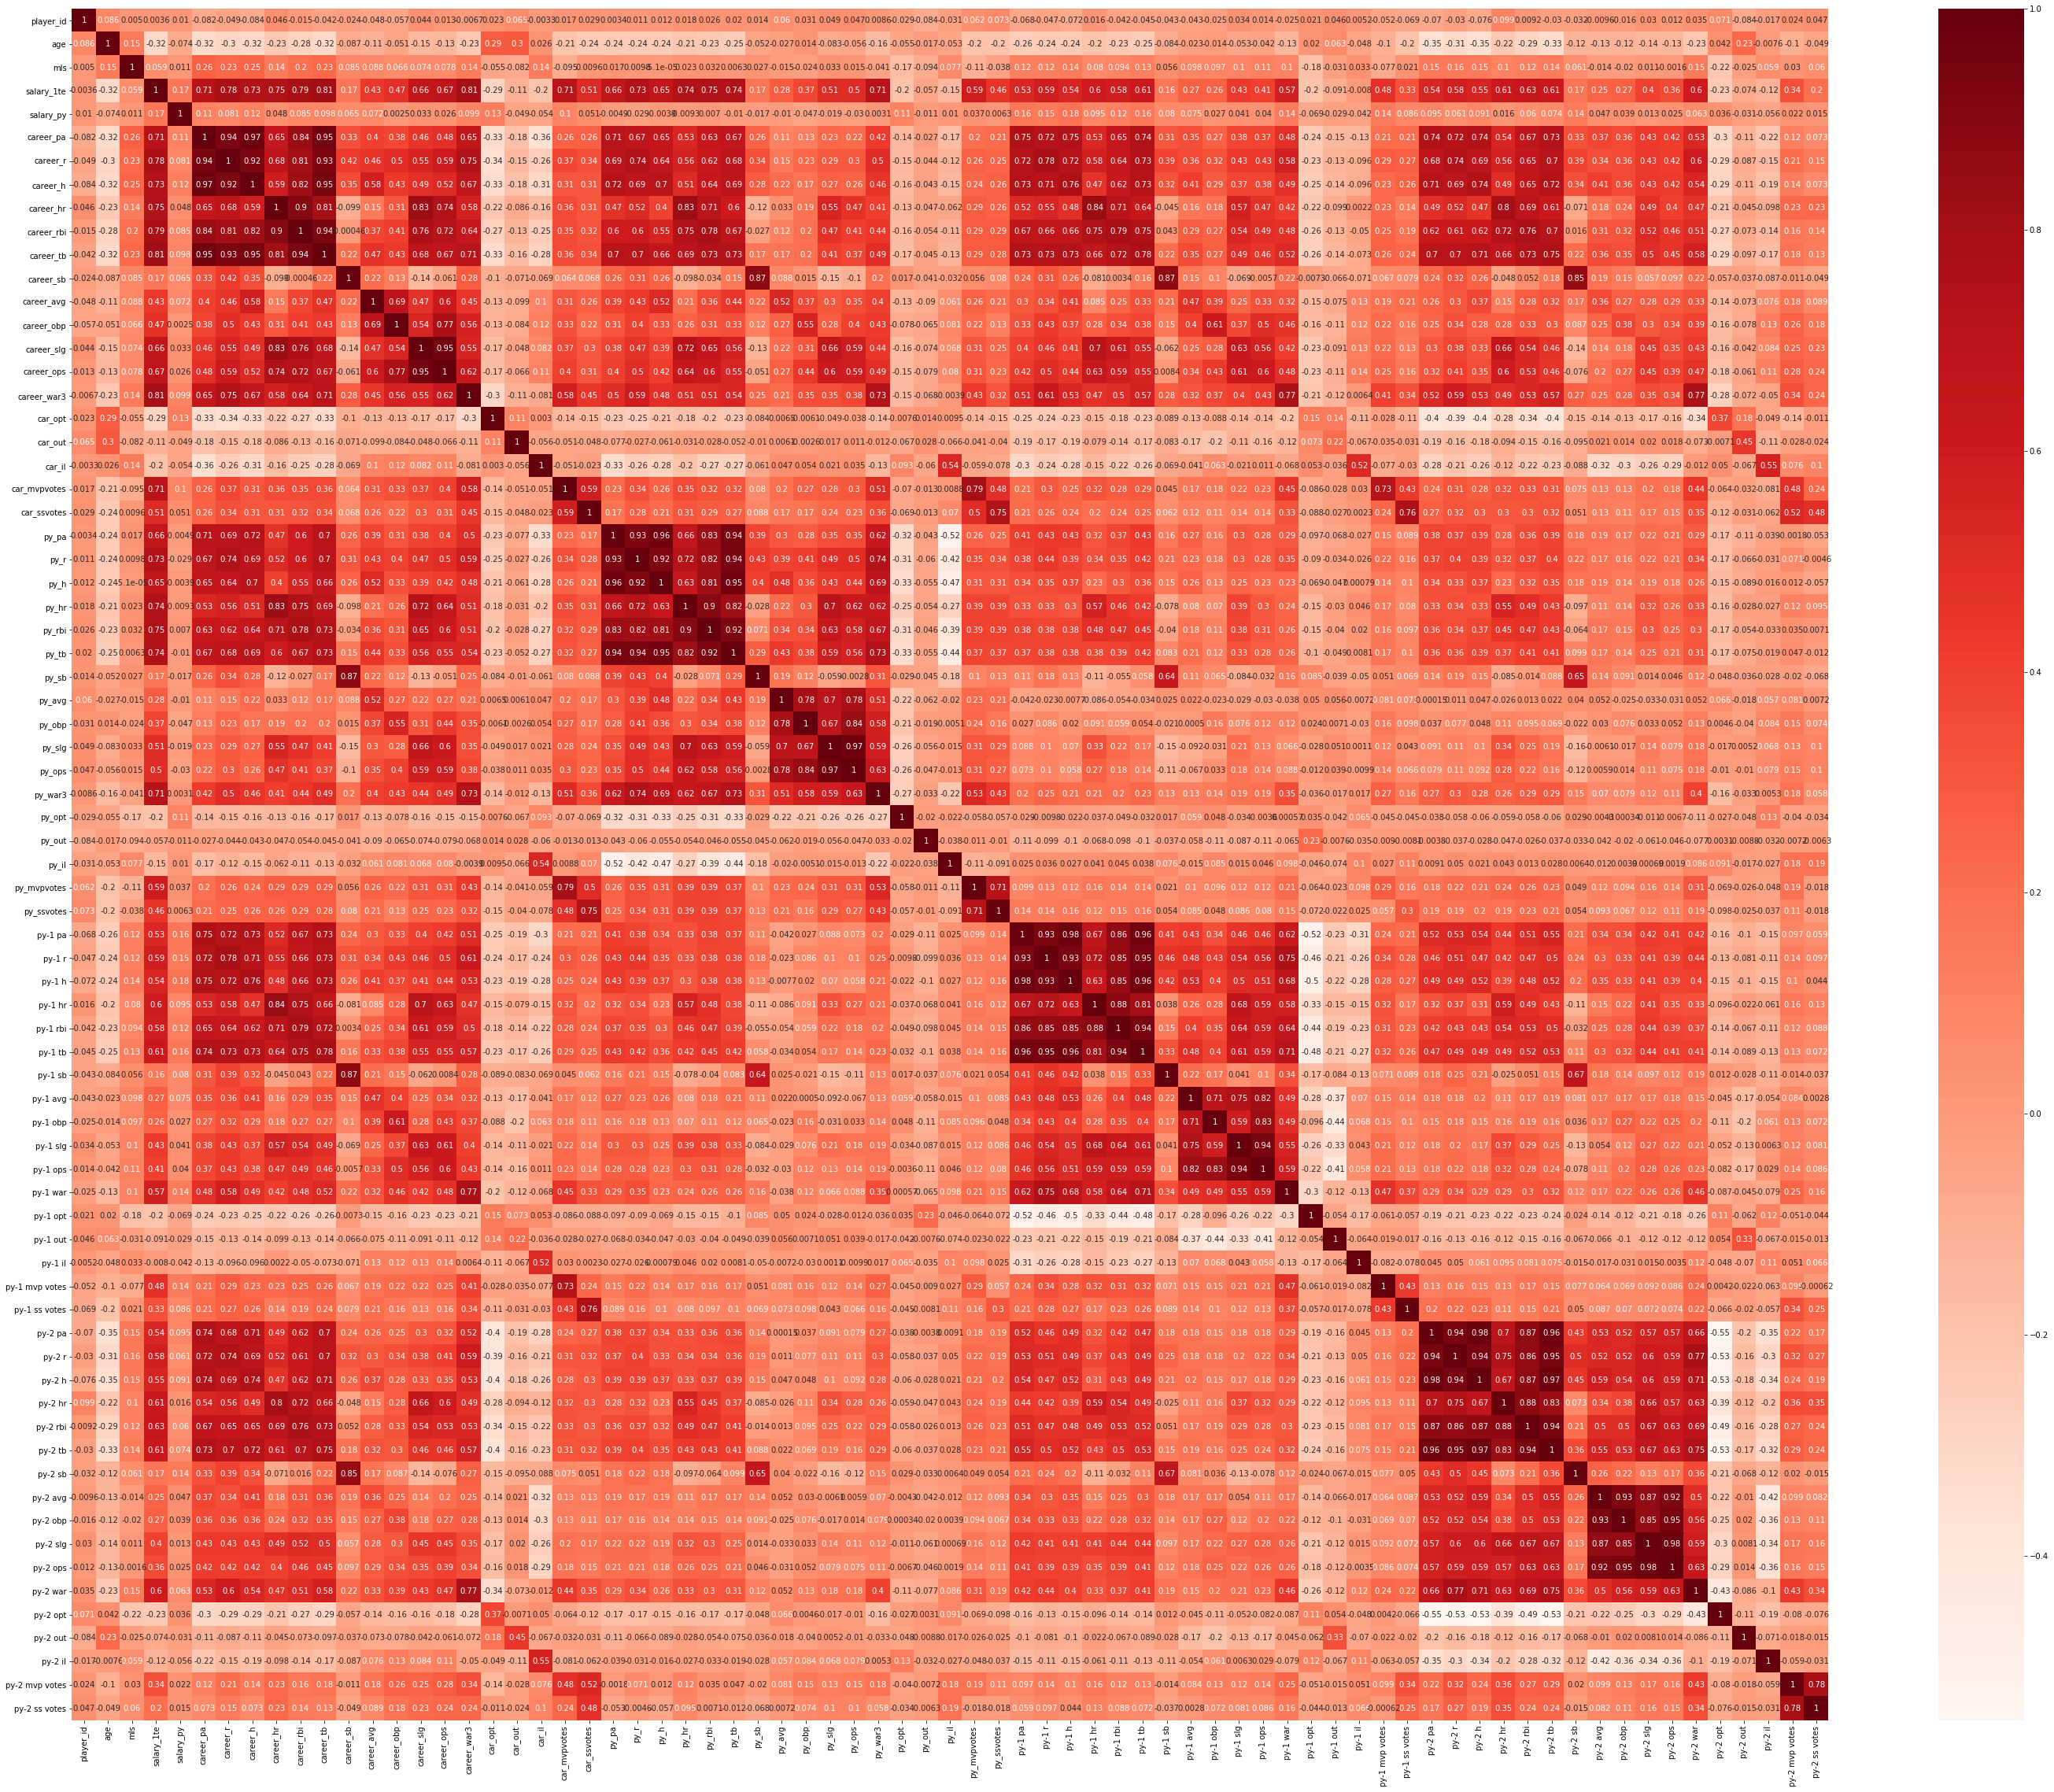

In [5]:
#Pearson Correlation Heatmap
plt.figure(figsize=(50, 40))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### 2.3 Missing Value Imputation

For the missing value in **py-2 war**, a popular approach to missing data imputation is to use a model to predict the missing values. This requires a model to be created for each input variable that has missing values. Although any one among a range of different models can be used to predict the missing values, the k-nearest neighbor (KNN) algorithm has proven to be generally effective, often referred to as “nearest neighbor imputation.

In [6]:
df.columns[df.isna().any()].tolist()

['py-2 war']

In [7]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

## 3. Model Building and Hyperparameter Tuning

After preprocessing, I defined my machine learning problem. Again, my goal was to predict a player’s **first-time eligible arbitration salary**. Therefore, on the basis of the given data, I was able to regard **salary_1te** as my label and further considered our problem as a regression problem. Besides, I included all of the features except **player_id** and **salary_1te** as my predictors. In this section, I defined two important functions to assist me in building classification models and tuning their hyperparameters.

In detail, I applied *LightGBM*, a gradient boosting framework that uses tree based learning algorithms, to my classification problem. It is designed to be distributed and efficient with the following advantages: faster training speed and higher efficiency, lower memory usage, better accuracy, capable of handling large-scale data, and support of parallel, distributed, and GPU learning. Next, regarding hyperparameter tuning, I used *Bayesian Optimization* instead of Grid Search and Random Search since Bayesian Optimization is far more efficient in saving time and has better overall performance.

In [8]:
# define a function to tune parameters using baysian optimization
def bayes_tuning(X_train, y_train, model_name, init_round=25, opt_round=20, random_state=42):
    
    info = r_model_info
    model = info[model_name][0]
    given_params = info[model_name][1]
    tuned_params = info[model_name][2]
    
    def cal_function(**fields):
        MAX_MIN_FIELDS = ['learning_rate']
        INT_ROUND_FIELD = ['n_neighbors',
                           'max_depth',
                           'min_samples_leaf',
                           'min_samples_split',
                           'n_estimators',
                           'num_leaves',
                           'min_child_samples']     
        for (key, value) in fields.items():
            if key in MAX_MIN_FIELDS:
                given_params[key] = max(min(value, 1), 0)
            elif key in INT_ROUND_FIELD:
                given_params[key] = int(round(value))
        return predict(given_params)
    
    def predict(params):
        rm = model
        rm.set_params(**params)
        cv = cross_val_score(rm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        metric = np.mean(cv)
        return metric
    
    BO = BayesianOptimization(cal_function, tuned_params, random_state=42)       
    BO.maximize(init_points=init_round, n_iter=opt_round)
    model_mse = []
    for model in range(len(BO.res)):
        model_mse.append(BO.res[model]['target'])
        
    return BO.res[pd.Series(model_mse).idxmax()]['target'], BO.res[pd.Series(model_mse).idxmax()]['params']

In [9]:
# define a function to fit the data with the optimal parameters
def model_fitting(X, y, model_name, optimal_params):
    
    info = r_model_info
    model = info[model_name][0]
    given_params = info[model_name][1]
    
    for param in optimal_params[1].keys():
        if param == 'learning_rate':
            optimal_params[1][param] = round(optimal_params[1][param], 2)
        else:
            optimal_params[1][param] = int(round(optimal_params[1][param]))
    given_params.update(optimal_params[1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)    
    rm = model
    rm.set_params(**given_params)
    rm.fit(X_train, y_train)
    y_pred = rm.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    output = [rm, round(mse, 2), round(100*mape, 2)]
    
    return output

## 4. Model Evaluation
### 4.1 Overview

After defining two functions for model building and hyperparameter tuning, I then checked the distribution of my response, **salary_1te**. 

If there is an imbalanced problem for regression, it's common to perform a data transformation or a over-sampling technique such as SMOGN (Synthetic Minority Over-Sampling Technique for Regression with Gaussian Noise). It did seem like my dataset was a bit imbalanced, so I performed SMOGN later to compare with the basic model.

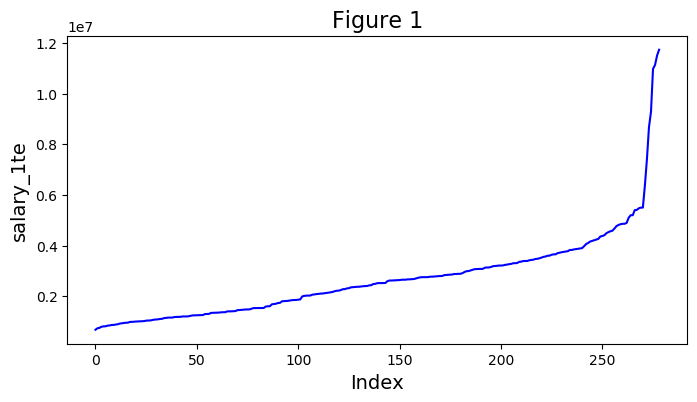

In [10]:
# First-time eligible arbitration salary distribution
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(df.shape[0]), np.sort(df['salary_1te']), color='blue')
ax.set_title('Figure 1', fontsize=16)
ax.set_xlabel('Index', fontsize=14)
ax.set_ylabel('salary_1te', fontsize=14)
plt.show()

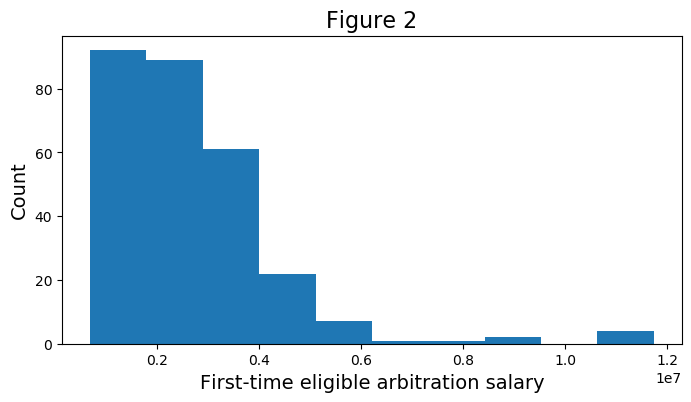

In [11]:
# First-time eligible arbitration salary distribution (2)
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df['salary_1te'])
ax.set_title('Figure 2', fontsize=16)
ax.set_xlabel('First-time eligible arbitration salary', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.show()

### 4.2 Basic Model

The first model represented that I used a regression model to predict **salary_1te** without any data transformation or over-sampling techniques. Therefore, in this section, I was able to use the two defined functions in section 3 to train three regression models, including k-nearest neighbors, random forest, and LightGBM, separately. After that, I evaluated their performances using test **MSE (Mean Squared Error)** and test **MAPE (Mean Absolute Percentage Error)**.

As shown in the below table, the **random forest regressor**, outperforms the **k-nearest neighbors regressor** and the **LightGBM regressor** on both test **MSE** and test **MAPE**. Furthermore, I checked the distributions of the true salary_1te and the predicted salary_1te of the three regressors. As shown in the below figures, it's obvious that the three regressors are all largely affected by the high number of salary where salary_1te is over about 5M.

In [12]:
# model information
r_model_info = {'knn': [KNeighborsRegressor(),
                        {'weights':'distance'},
                        {'n_neighbors':(1,20)}],
                'rf': [RandomForestRegressor(),
                       {'criterion':'mse', 'max_features':'auto'},
                       {'max_depth':(10,50), 'min_samples_leaf':(2,5),
                        'min_samples_split':(2,5), 'n_estimators':(100,500)}],
                'lightgbm': [lgb.LGBMRegressor(),
                             {'boosting_type':'gbdt'},
                             {'learning_rate':(0.01,1.0), 'num_leaves':(30,200),
                              'max_depth':(1,30), 'min_child_samples':(20,80)}]}

In [13]:
# regression model training
X = df.drop(['player_id', 'salary_1te'], axis=1).to_numpy()
y = df['salary_1te'].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knnr_optimal_params = bayes_tuning(X_train, y_train, 'knn')
knnr_results = model_fitting(X, y, 'knn', knnr_optimal_params)
rfr_optimal_params = bayes_tuning(X_train, y_train, 'rf')
rfr_results = model_fitting(X, y, 'rf', rfr_optimal_params)
lgbr_optimal_params = bayes_tuning(X_train, y_train, 'lightgbm')
lgbr_results = model_fitting(X, y, 'lightgbm', lgbr_optimal_params)

|   iter    |  target   | n_neig... |
-------------------------------------
|  1        | -2.78e+12 |  8.116    |
|  2        | -2.6e+12  |  19.06    |
|  3        | -2.674e+1 |  14.91    |
|  4        | -2.685e+1 |  12.37    |
|  5        | -3.055e+1 |  3.964    |
|  6        | -3.055e+1 |  3.964    |
|  7        | -3.213e+1 |  2.104    |
|  8        | -2.635e+1 |  17.46    |
|  9        | -2.685e+1 |  12.42    |
|  10       | -2.688e+1 |  14.45    |
|  11       | -4.124e+1 |  1.391    |
|  12       | -2.6e+12  |  19.43    |
|  13       | -2.635e+1 |  16.82    |
|  14       | -2.9e+12  |  5.034    |
|  15       | -3.055e+1 |  4.455    |
|  16       | -3.055e+1 |  4.485    |
|  17       | -2.804e+1 |  6.781    |
|  18       | -2.7e+12  |  10.97    |
|  19       | -2.752e+1 |  9.207    |
|  20       | -2.804e+1 |  6.533    |
|  21       | -2.691e+1 |  12.63    |
|  22       | -3.055e+1 |  3.65     |
|  23       | -2.804e+1 |  6.551    |
|  24       | -2.78e+12 |  7.961    |
|  25       

In [14]:
# test mse and test mape
model_names = ['K-Nearest Neighbors', 'Random Forest', 'LightGBM']
m1 = {'MSE': [knnr_results[1], rfr_results[1], lgbr_results[1]],
      'MAPE (%)': [knnr_results[2], rfr_results[2], lgbr_results[2]]}
metric_df = pd.DataFrame(data=m1, index=model_names)
metric_df

,MSE,MAPE (%)
K-Nearest Neighbors,2.453294e+12,40.39
Random Forest,3.627309e+11,9.33
LightGBM,5.926822e+11,12.74


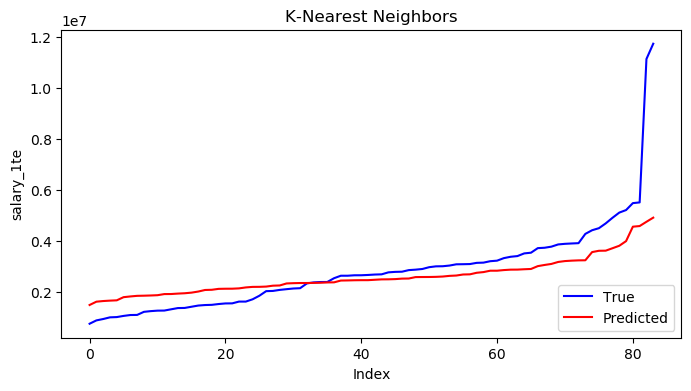

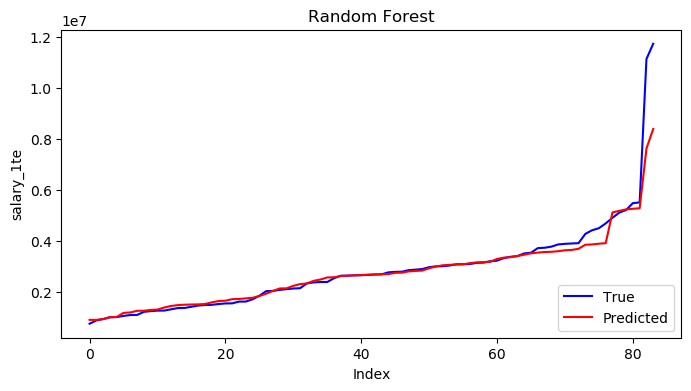

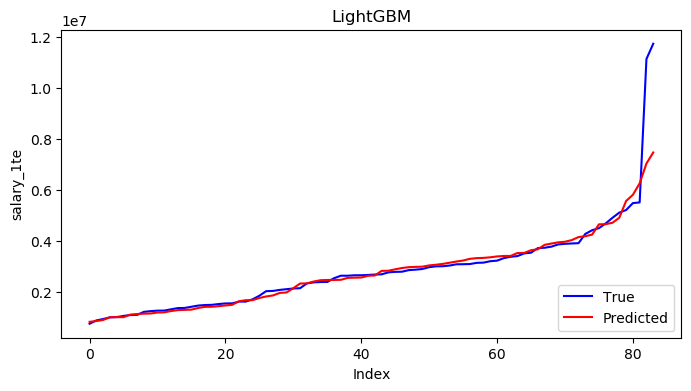

In [15]:
# true value and predicted value
preds = [knnr_results[0].predict(X_test), rfr_results[0].predict(X_test), lgbr_results[0].predict(X_test)]
for i in range(len(preds)):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(range(len(y_test)), np.sort(y_test), color='blue')
    ax.plot(range(len(y_test)), np.sort(preds[i]), color='red')
    ax.set_title(model_names[i])
    ax.set_xlabel('Index')
    ax.set_ylabel('salary_1te')    
    line = [Line2D([0], [0], color=c, linewidth=1.5) for c in ['blue', 'red']]
    label = ['True', 'Predicted']
    plt.legend(line, label, loc=4)
    plt.show()

### 4.3 SMOGN Model

In [16]:
## conduct smogn
df_smogn = df.drop(['player_id'], axis=1)

df_smogn = smogn.smoter(

    data = df_smogn, 
    y = "salary_1te"
)

# regression model training
X = df_smogn.drop(['salary_1te'], axis=1).to_numpy()
y = df_smogn['salary_1te'].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knnr_optimal_params_smogn = bayes_tuning(X_train, y_train, 'knn')
knnr_results_smogn = model_fitting(X, y, 'knn', knnr_optimal_params_smogn)
rfr_optimal_params_smogn = bayes_tuning(X_train, y_train, 'rf')
rfr_results_smogn = model_fitting(X, y, 'rf', rfr_optimal_params_smogn)
lgbr_optimal_params_smogn = bayes_tuning(X_train, y_train, 'lightgbm')
lgbr_results_smogn = model_fitting(X, y, 'lightgbm', lgbr_optimal_params_smogn)

r_index: 100%|#########################################################################| 29/29 [00:00<00:00, 34.67it/s]


|   iter    |  target   | n_neig... |
-------------------------------------
|  1        | -3.959e+1 |  8.116    |
|  2        | -3.847e+1 |  19.06    |
|  3        | -3.852e+1 |  14.91    |
|  4        | -3.887e+1 |  12.37    |
|  5        | -4.121e+1 |  3.964    |
|  6        | -4.121e+1 |  3.964    |
|  7        | -4.473e+1 |  2.104    |
|  8        | -3.855e+1 |  17.46    |
|  9        | -3.887e+1 |  12.42    |
|  10       | -3.849e+1 |  14.45    |
|  11       | -5.106e+1 |  1.391    |
|  12       | -3.847e+1 |  19.43    |
|  13       | -3.855e+1 |  16.82    |
|  14       | -4.145e+1 |  5.034    |
|  15       | -4.121e+1 |  4.455    |
|  16       | -4.121e+1 |  4.485    |
|  17       | -4.03e+12 |  6.781    |
|  18       | -3.912e+1 |  10.97    |
|  19       | -3.927e+1 |  9.207    |
|  20       | -4.03e+12 |  6.533    |
|  21       | -3.901e+1 |  12.63    |
|  22       | -4.121e+1 |  3.65     |
|  23       | -4.03e+12 |  6.551    |
|  24       | -3.959e+1 |  7.961    |
|  25       

In [17]:
# test mse and test mape
model_names = ['K-Nearest Neighbors', 'Random Forest', 'LightGBM']
m2 = {'MSE': [knnr_results_smogn[1], rfr_results_smogn[1], lgbr_results_smogn[1]],
      'MAPE (%)': [knnr_results_smogn[2], rfr_results_smogn[2], lgbr_results_smogn[2]]}
metric_df_smogn = pd.DataFrame(data=m2, index=model_names)
metric_df_smogn

,MSE,MAPE (%)
K-Nearest Neighbors,6.089431e+12,68.34
Random Forest,3.892917e+11,11.09
LightGBM,4.340089e+11,10.69


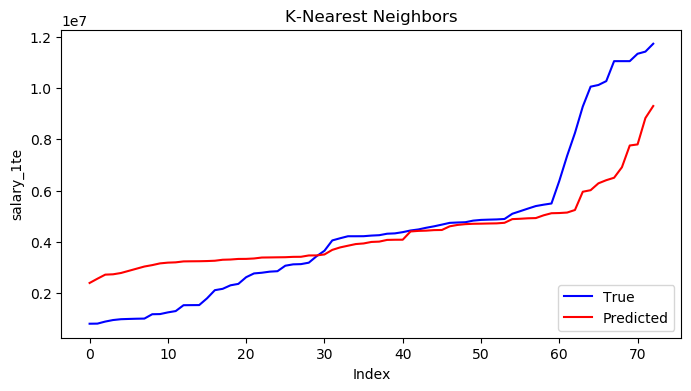

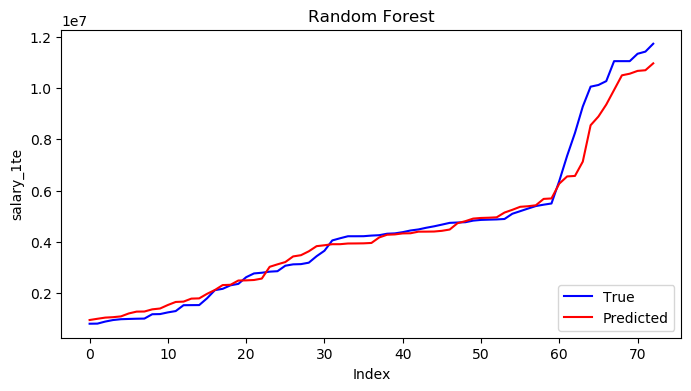

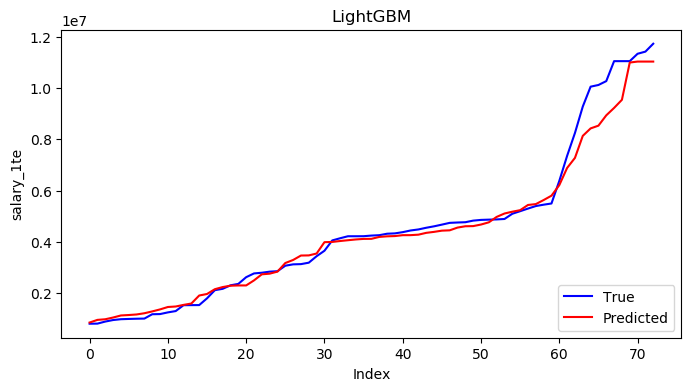

In [18]:
# true value and predicted value
preds = [knnr_results_smogn[0].predict(X_test), rfr_results_smogn[0].predict(X_test), lgbr_results_smogn[0].predict(X_test)]
for i in range(len(preds)):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(range(len(y_test)), np.sort(y_test), color='blue')
    ax.plot(range(len(y_test)), np.sort(preds[i]), color='red')
    ax.set_title(model_names[i])
    ax.set_xlabel('Index')
    ax.set_ylabel('salary_1te')    
    line = [Line2D([0], [0], color=c, linewidth=1.5) for c in ['blue', 'red']]
    label = ['True', 'Predicted']
    plt.legend(line, label, loc=4)
    plt.show()

## 5. First-Time Eligible Arbitration Salary Prediction

Again, the goal of this task was to develop a reliable framework which is capable of predicting **first-time eligible arbitration salary** for players and placing them into tiers. SMOGN models were not better with worse MSE and MAPE than the basic models. I was able to use the proposed **basic Random Forest model** to make the predictions. Then, I checked the distribution of the predicted salary. As shown in the below figure, there were two groups of the predicted salary. Therefore, I decided to place the first-time eligible arbitration salary into two tiers. The first tier represents the salary which is projected to be over 8M. The second tier represents the salary which is projected to be under around 6M.

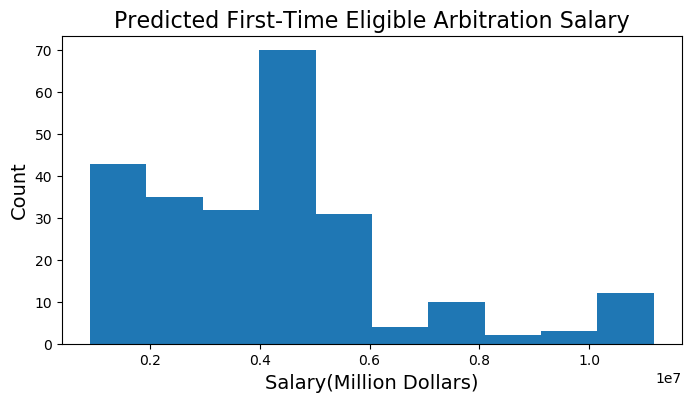

In [19]:
# prediction
pred = rfr_results[0].predict(X)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pred)
ax.set_title('Predicted First-Time Eligible Arbitration Salary', fontsize=16)
ax.set_xlabel('Salary(Million Dollars)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.show()

## Potential variables that may improve the model

As for the variables not provided in the dataset that I think would be useful to improving the model include
1.Advanced metrics like xwOBA, wRC+, DRC+, xERA, FIP, DRA-, Def, OAA, DRS from career, py, py-1, py-2
2.Minor league non-accumulative stats. How long a player stay in the minor league may not correlate well with his ability, however stats like batting average, on-base percentage could still contribute to my model.
3.Gold glove votes through career, py, py-1, py-2

## Limitation
Although the basic(non-SMOGN) random forest model with hyperparameter tuning had the best performance, when we try to predict those who may earn more than 8M in their first-time eligible arbitration salary, we might want to combine our predictions from the basic model and SMOGN model to make a better assessment.